In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!wget http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz
!mkdir speech_commands
!tar -xf speech_commands_v0.02.tar.gz -C speech_commands
%cd speech_commands


--2025-05-18 17:28:32--  http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.250.125.207, 142.251.183.207, 209.85.200.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|142.250.125.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2428923189 (2.3G) [application/gzip]
Saving to: ‘speech_commands_v0.02.tar.gz’

speech_commands_v0. 100%[===================>]   2.26G   402MB/s    in 5.9s    

2025-05-18 17:28:38 (395 MB/s) - ‘speech_commands_v0.02.tar.gz’ saved [2428923189/2428923189]

/content/speech_commands


In [ ]:
import os
import shutil

DATA_PATH = "."
KEEP = {"go", "stop", "yes", "no", "off"}

for folder in os.listdir(DATA_PATH):
    folder_path = os.path.join(DATA_PATH, folder)
    if os.path.isdir(folder_path) and folder not in KEEP:
        shutil.rmtree(folder_path)
print("Removed unwanted folders, kept only:", KEEP)

Removed unwanted folders, kept only: {'no', 'go', 'yes', 'off', 'stop'}


In [ ]:
import os
import shutil
import random

# Current directory: speech_commands/
DATA_PATH = "."  # This is your current working directory
OUTPUT_PATH = "../organized_data"  # This creates the split folder one level up
COMMANDS = ["go", "stop", "yes", "no", "off"]
SPLITS = {"train": 0.7, "validation": 0.15, "test": 0.15}

# Create destination folders outside speech_commands/
for split in SPLITS:
    for cmd in COMMANDS:
        os.makedirs(os.path.join(OUTPUT_PATH, split, cmd), exist_ok=True)

# Shuffle and distribute files
for cmd in COMMANDS:
    src_folder = os.path.join(DATA_PATH, cmd)
    files = [f for f in os.listdir(src_folder) if f.endswith(".wav")]
    random.shuffle(files)

    n_total = len(files)
    n_train = int(n_total * SPLITS["train"])
    n_val = int(n_total * SPLITS["validation"])
    n_test = n_total - n_train - n_val

    train_files = files[:n_train]
    val_files = files[n_train:n_train + n_val]
    test_files = files[n_train + n_val:]

    for f in train_files:
        shutil.copy(os.path.join(src_folder, f), os.path.join(OUTPUT_PATH, "train", cmd, f))

    for f in val_files:
        shutil.copy(os.path.join(src_folder, f), os.path.join(OUTPUT_PATH, "validation", cmd, f))

    for f in test_files:
        shutil.copy(os.path.join(src_folder, f), os.path.join(OUTPUT_PATH, "test", cmd, f))

print("✅ Data has been split and saved to: ../organized_data/")


✅ Data has been split and saved to: ../organized_data/


In [ ]:
import os
import librosa
import numpy as np

# Path to the organized dataset
BASE_DIR = "../organized_data"

# Output folder
OUTPUT_DIR = "../features"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Audio + MFCC settings
SAMPLE_RATE = 16000
DURATION = 1
SAMPLES = SAMPLE_RATE * DURATION
N_MFCC = 13
MAX_LEN = 32

def extract_features(split):
    X = []
    y = []
    split_path = os.path.join(BASE_DIR, split)
    label_names = sorted(os.listdir(split_path))
    label_map = {label: idx for idx, label in enumerate(label_names)}

    for label in label_names:
        folder = os.path.join(split_path, label)
        for file in os.listdir(folder):
            if not file.endswith('.wav'):
                continue

            path = os.path.join(folder, file)
            audio, sr = librosa.load(path, sr=SAMPLE_RATE)

            if len(audio) < SAMPLES:
                audio = np.pad(audio, (0, SAMPLES - len(audio)))
            else:
                audio = audio[:SAMPLES]

            mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=N_MFCC).T

            if mfcc.shape[0] < MAX_LEN:
                mfcc = np.pad(mfcc, ((0, MAX_LEN - mfcc.shape[0]), (0, 0)))
            else:
                mfcc = mfcc[:MAX_LEN, :]

            X.append(mfcc)
            y.append(label_map[label])

    return np.array(X), np.array(y), label_map

# Extract all splits
X_train, y_train, label_map = extract_features("train")
X_val, y_val, _ = extract_features("validation")
X_test, y_test, _ = extract_features("test")

# Save to features/ folder
np.save(os.path.join(OUTPUT_DIR, "X_train.npy"), X_train)
np.save(os.path.join(OUTPUT_DIR, "y_train.npy"), y_train)
np.save(os.path.join(OUTPUT_DIR, "X_val.npy"), X_val)
np.save(os.path.join(OUTPUT_DIR, "y_val.npy"), y_val)
np.save(os.path.join(OUTPUT_DIR, "X_test.npy"), X_test)
np.save(os.path.join(OUTPUT_DIR, "y_test.npy"), y_test)

# Optional: save label map as a .txt file
with open(os.path.join(OUTPUT_DIR, "label_map.txt"), "w") as f:
    for label, index in label_map.items():
        f.write(f"{index}: {label}\n")

print("✅ Features saved in 'features/' folder.")
print("📋 Label map:", label_map)


✅ Features saved in 'features/' folder.
📋 Label map: {'go': 0, 'no': 1, 'off': 2, 'stop': 3, 'yes': 4}


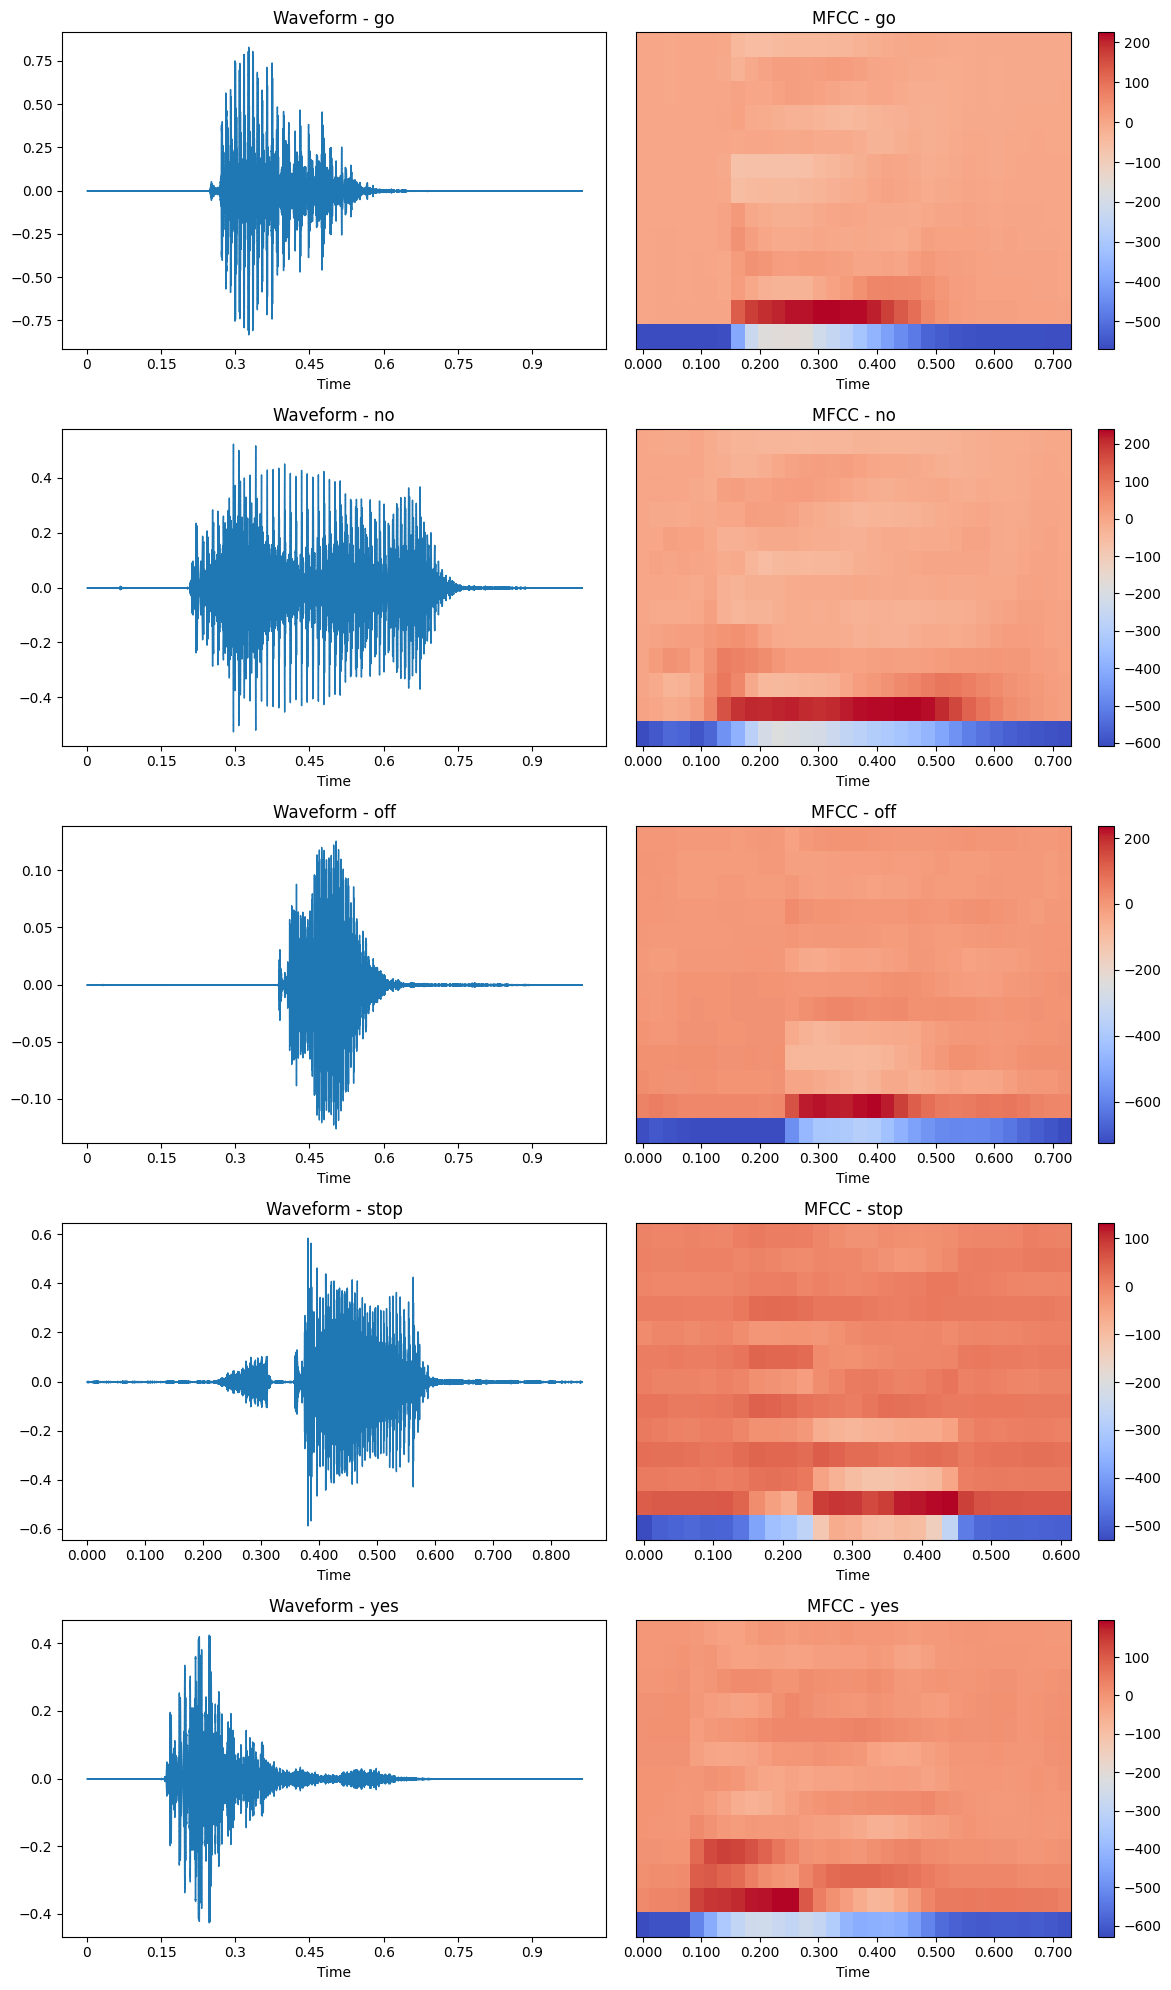

In [ ]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt

BASE_DIR = "../organized_data/train"
SAMPLE_RATE = 16000
N_MFCC = 13

# Get list of command folders
commands = sorted(os.listdir(BASE_DIR))

plt.figure(figsize=(12, 4 * len(commands)))

for i, command in enumerate(commands):
    folder = os.path.join(BASE_DIR, command)
    files = [f for f in os.listdir(folder) if f.endswith('.wav')]
    if not files:
        continue

    # Use first available file
    file_path = os.path.join(folder, files[0])
    audio, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=N_MFCC)

    # Waveform
    plt.subplot(len(commands), 2, 2 * i + 1)
    librosa.display.waveshow(audio, sr=sr)
    plt.title(f"Waveform - {command}")

    # MFCC
    plt.subplot(len(commands), 2, 2 * i + 2)
    librosa.display.specshow(mfcc, x_axis='time')
    plt.colorbar()
    plt.title(f"MFCC - {command}")

plt.tight_layout()
plt.show()


In [ ]:
pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 83.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 105.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 92.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 117.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.6 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Load features
X_train = np.load(os.path.join(OUTPUT_DIR, "X_train.npy"))
y_train = np.load(os.path.join(OUTPUT_DIR, "y_train.npy"))
X_val = np.load(os.path.join(OUTPUT_DIR, "X_val.npy"))
y_val = np.load(os.path.join(OUTPUT_DIR, "y_val.npy"))
X_test = np.load(os.path.join(OUTPUT_DIR, "X_test.npy"))
y_test = np.load(os.path.join(OUTPUT_DIR, "y_test.npy"))


In [ ]:
# Model architecture
model = models.Sequential([
    layers.Input(shape=(MAX_LEN, N_MFCC)),
    layers.Conv1D(64, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(2),
    layers.Conv1D(128, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(2),
    layers.Conv1D(256, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(2),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(COMMANDS), activation='softmax')
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 30, 64)         │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 13, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 4, 256)         │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 2, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 260,229 (1016.52 KB)

 Trainable params: 259,333 (1013.02 KB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
# Training
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=3)
    ]
)

Epoch 1/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.7109 - loss: 0.8204 - val_accuracy: 0.9072 - val_loss: 0.2594 - learning_rate: 0.0010
Epoch 2/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9074 - loss: 0.2708 - val_accuracy: 0.9387 - val_loss: 0.1762 - learning_rate: 0.0010
Epoch 3/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9293 - loss: 0.2029 - val_accuracy: 0.9336 - val_loss: 0.1816 - learning_rate: 0.0010
Epoch 4/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9313 - loss: 0.1904 - val_accuracy: 0.9281 - val_loss: 0.2142 - learning_rate: 0.0010
Epoch 5/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9449 - loss: 0.1585 - val_accuracy: 0.9452 - val_loss: 0.1678 - learning_rate: 0.0010
Epoch 6/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9474 - loss: 0.1470 - val_accuracy: 0.9558 - val_loss: 0.1357 - learning_rate: 0.0010
Epoch 7/30
427/427 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9522 - loss: 0.

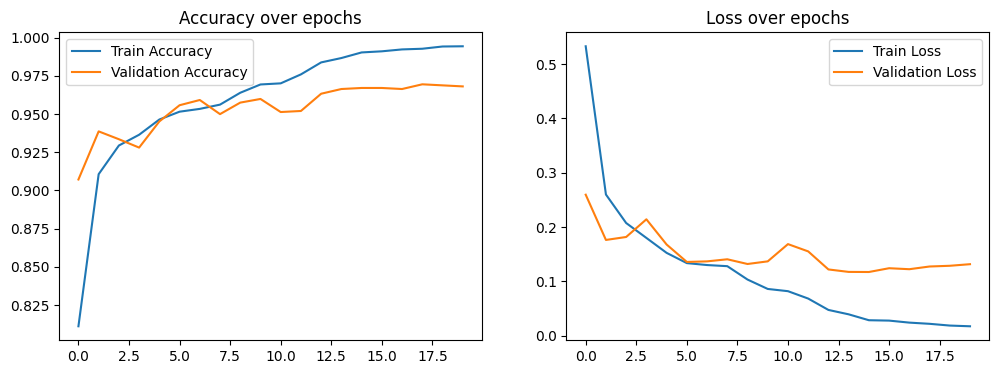

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.legend()
plt.show()

In [ ]:
# Evaluation
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_acc:.4f}")


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9359 - loss: 0.2270

Test Accuracy: 0.9542


In [ ]:
# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
print(y_pred_classes)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
[0 0 0 ... 4 4 4]



Classification Report:
              precision    recall  f1-score   support

          go       0.92      0.93      0.92       582
          no       0.94      0.93      0.94       592
         off       0.96      0.97      0.96       563
        stop       0.97      0.96      0.97       582
         yes       0.98      0.98      0.98       608

    accuracy                           0.95      2927
   macro avg       0.95      0.95      0.95      2927
weighted avg       0.95      0.95      0.95      2927



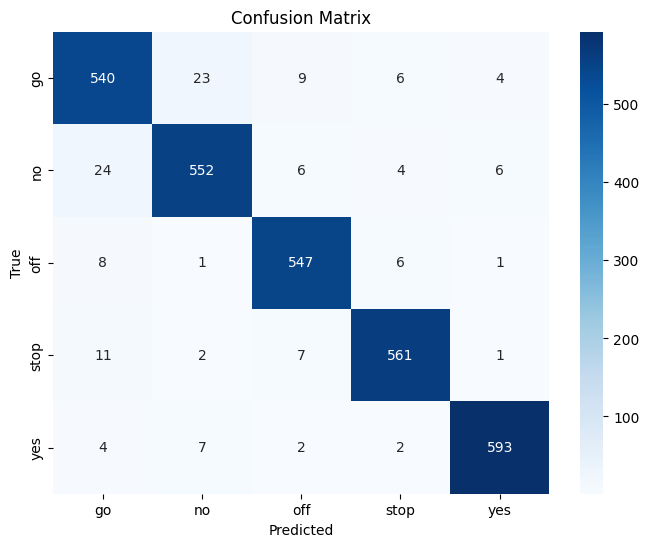

In [ ]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=label_map.keys()))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_map.keys(),
            yticklabels=label_map.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Save the model
model.save("../command_model.keras")

In [ ]:
model.save("../command_model.h5")


In [ ]:
model.save("model_compatible.h5", include_optimizer=False)
